In [1]:
from collections import defaultdict
from datetime import datetime
from functools import partial  # NOQA: F401
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader  # NOQA: F401
from torchmetrics.detection import MeanAveragePrecision
from torchvision.io import read_image, ImageReadMode
from torchvision.models.detection.fcos import fcos_resnet50_fpn, FCOSClassificationHead
from torchvision.transforms.v2 import functional as trx
from tqdm import tqdm

from line_profiler import profile

op = os.path
ORG_LABELS = {
    "aegypti": 0,
    "albopictus": 1,
    "anopheles": 2,
    "culex": 3,
    "culiseta": 4,
    "japonicus/koreicus": 5,
}
LABELS = {k: v + 1 for k, v in ORG_LABELS.items()}
ID2LABEL = {v: k for k, v in LABELS.items()}
BAR_FORMAT = "{l_bar}{bar}| {n_fmt}/{total_fmt} {rate_fmt}{postfix}"
MIN_SIZE, MAX_SIZE = 800, 1333

In [2]:
class TrainDataset(Dataset):
    def __init__(self, df, root, device=None):
        self.df = df
        self.root = root
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = op.join(self.root, "images", f"{row['id']}.jpeg")
        image = read_image(path, ImageReadMode.RGB)
        image = trx.to_dtype(image, torch.float32, scale=True)
        _, im_height, im_width = image.shape
        x_center, y_center, width, height = row[
            ["x_center", "y_center", "width", "height"]
        ]
        x_center, width = x_center * im_width, width * im_width
        y_center, height = y_center * im_height, height * im_height
        x0, y0 = x_center - width / 2, y_center - height / 2
        x1, y1 = x_center + width / 2, y_center + height / 2
        boxes = torch.tensor([x0, y0, x1, y1], dtype=torch.float32).unsqueeze(0)
        labels = torch.tensor([row["label"] + 1], dtype=torch.int64)
        return image, {"boxes": boxes, "labels": labels}

    def show(self, n, model=None, seed=None):
        fig, ax = plt.subplots(nrows=n, ncols=n, figsize=(3 * n, 3 * n))
        if seed is not None:
            np.random.seed(seed)
        samples = [self[i] for i in np.random.choice(len(self), size=n * n)]
        preds = []
        for (im, box), ax in zip(samples, ax.ravel()):
            ax.imshow(im.permute(1, 2, 0))
            x0, y0, x1, y1 = box["boxes"][0]
            ax.add_patch(
                plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor="green")
            )
            fig_label = ID2LABEL[box["labels"][0].item()]
            if model is not None:
                model.eval()
                with torch.no_grad():
                    pred = model([im.to(self.device)])
                preds.append(pred[0])
                ix = pred[0]["scores"].argmax().item()
                predbox = pred[0]["boxes"][ix]
                predlabel = ID2LABEL[pred[0]["labels"][ix].item()]
                x0, y0, x1, y1 = predbox.cpu().numpy()
                ax.add_patch(
                    plt.Rectangle(
                        (x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor="red"
                    )
                )
                fig_label = f"{fig_label} ({predlabel})"
            ax.set_axis_off()
            ax.set_title(fig_label, fontsize="small")
        plt.tight_layout()
        plt.savefig("foo.png", bbox_inches="tight")
        return preds, samples


def make_df(root, stratify=False, test_size=0.2):
    images_path = op.join(root, "images")
    labels_path = op.join(root, "labels")
    image_files = [
        op.join(images_path, f) for f in os.listdir(images_path) if f.endswith(".jpeg")
    ]
    payload = []
    for file in image_files:
        image_id = op.splitext(op.basename(file))[0]
        label_file = op.join(labels_path, f"{image_id}.txt")
        with open(label_file, "r") as f_in:
            label, x_center, y_center, width, height = map(
                float, f_in.read().strip().split()
            )
            label = int(label)

        payload.append(
            dict(
                id=image_id,
                label=label,
                x_center=x_center,
                y_center=y_center,
                width=width,
                height=height,
            )
        )
    df = pd.DataFrame.from_records(payload)
    if not stratify:
        return df
    area = df["width"] * df["height"]
    area_cat = pd.cut(area, bins=np.linspace(0, 1, 6), labels=list("ABCDE"))
    strf_cat = df["label"].astype(int).astype(str) + area_cat.astype(str)
    return train_test_split(df, stratify=strf_cat, test_size=test_size)


def get_model(device=None):
    model = fcos_resnet50_fpn(weights="COCO_V1")  # , trainable_backbone_layers=0)
    for p in model.parameters():
        p.requires_grad = False
    model.head.classification_head = FCOSClassificationHead(
        in_channels=256, num_anchors=model.head.classification_head.num_anchors,
        num_classes=len(LABELS)+1
    )
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return model.to(device)


def load_model(path):
    model = get_model()
    model.load_state_dict(torch.load(path, weights_only=True))
    return model


def resize_with_ar(image, box):
    """Resize an image to exactly MIN_SIZE by MAX_SIZE. Transpose if needed."""
    h, w = image.shape[-2:]
    if h < w:  # landscape
        new_image = trx.resize(image, (MIN_SIZE, MAX_SIZE))
        box[::2] *= MAX_SIZE / w
        box[1::2] *= MIN_SIZE / h
    else:
        new_image = trx.resize(image, (MAX_SIZE, MIN_SIZE)).permute(0, 2, 1)
        box[::2] *= MIN_SIZE / w
        box[1::2] *= MAX_SIZE / h
    return new_image, box


def collate(batch, device=False, resize=True):
    images, targets = zip(*batch)
    if resize:
        images, bboxes = zip(*[resize_with_ar(im, t["boxes"][0]) for im, t in zip(images, targets)])
        new_targets = []
        for b, l in zip(bboxes, targets):
            l["boxes"] = b.unsqueeze(0)
            l['labels'] = l['labels']
            new_targets.append(l)
        images = torch.stack(images)
        if device:
            images = images.to(device)
            new_targets = [{'labels': i['labels'].to(device), 'boxes': i['boxes'].to(device)} for i in new_targets]
    elif device:
        images = [i.to(device) for i in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    return images, targets


def update_history(cache, patience=1, **kwargs):
    report = []
    for metric in ["train_loss", "val_loss", "train_metric", "val_metric"]:
        if metric not in kwargs:
            continue
        cache[metric].append(kwargs[metric])
        window = cache[metric][-patience:]
        if len(cache[metric]) >= patience + 1:
            direction = "↓" if np.mean(window) <= cache[metric][-patience - 1] else "↑"
        else:
            direction = "⌾"

        # Last boolean denotes whether it is minimizing
        report.append((metric, direction, window[-1], metric.endswith("_loss")))
    return report


def update_postfix(bar, report, lr):
    bar.update(1)
    postfix_params = {}
    for metric, direction, value, minimizing in report:
        value = round(value, 3)
        if direction == "⌾":
            colored = f"\033[33m{value}{direction}\033[0m"
        if (minimizing and direction == "↓") or (not minimizing and direction == "↑"):
            colored = f"\033[32m{value}{direction}\033[0m"
        elif (minimizing and direction == "↑") or (not minimizing and direction == "↓"):
            colored = f"\033[31m{value}{direction}\033[0m"
        postfix_params[metric] = colored
    postfix_params["lr"] = f"{round(lr[-1], 6)}"
    bar.set_postfix(postfix_params, refresh=True)


def train(model, train_loader, test_loader, n_epochs=1, patience=3):
    opt = torch.optim.Adam(model.head.classification_head.parameters(), lr=0.001)
    # lr = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)
    b_len = len(train_loader) + len(test_loader)
    epoch_history = defaultdict(list)  # NOQA: F841
    with tqdm(desc="Epoch", total=n_epochs, bar_format=BAR_FORMAT) as ebar:
        for epoch in range(n_epochs):
            model.train()
            epoch_train_loss = epoch_val_loss = 0
            epoch_val_metric = 0
            for images, targets in train_loader:
                targets = [{
                    'labels': t['labels'].to(device),
                    'boxes': t['boxes'].to(device)
                } for t in targets]
                opt.zero_grad()
                loss_dict = model(images.to(device), targets)
                batch_train_loss = sum(loss for loss in loss_dict.values())
                batch_train_loss.backward()
                btl = batch_train_loss.item()
                opt.step()
                epoch_train_loss += btl
            epoch_train_loss /= len(train_loader)
            for images, targets in test_loader:
                targets = [{
                    'labels': t['labels'].to(device),
                    'boxes': t['boxes'].to(device)
                } for t in targets]
                with torch.no_grad():
                    preds = model(images.to(device), targets)
                batch_val_loss = sum(loss for loss in preds.values())
                epoch_val_loss += batch_val_loss.item()
                epoch_val_loss /= len(test_loader)
                epoch_val_metric /= len(test_loader)
            # lr.step()
            report = update_history(
                epoch_history,
                train_loss=epoch_train_loss,
                val_loss=epoch_val_loss,
                val_metric=epoch_val_metric,
                patience=patience,
            )
            update_postfix(ebar, report, [0.001])
    return epoch_history


def make_submission(
    model,
    root,
    outpath=None,
    show=0,
    seed=None,
    dfpath="data/sample_submission.csv",
    device=None,
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    df = pd.read_csv(dfpath, index_col="ImageID")
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        path = op.join(root, idx)
        image = read_image(path, ImageReadMode.RGB)
        image = trx.to_dtype(image, torch.float32, scale=True)
        with torch.no_grad():
            pred = model([image.to(device)])[0]
        try:
            ix = pred["scores"].argmax().item()
            conf = pred["scores"][ix].item()
            predbox = pred["boxes"][ix]
            label = ID2LABEL[pred["labels"][ix].item()]
            x0, y0, x1, y1 = predbox.cpu().numpy()
            _, im_height, im_width = image.shape
            xcenter, ycenter = (x0 + x1) / 2, (y0 + y1) / 2
            box_width, box_height = x1 - x0, y1 - y0
            xcenter, box_width = xcenter / im_width, box_width / im_width
            ycenter, box_height = ycenter / im_height, box_height / im_height
        except IndexError:
            label, conf, xcenter, ycenter, box_width, box_height = "albopictus", 0, 0, 0, 0, 0
        df.loc[idx, ['LabelName', 'Conf', 'xcenter', 'ycenter', 'bbx_width', 'bbx_height']] = [
            label, conf, xcenter, ycenter, box_width, box_height
        ]
    if outpath is None:
        outpath = "submission.csv"
    df.to_csv(outpath)
    if show:
        np.random.seed(seed)
        xdf = df.loc[np.random.choice(df.index, size=(show * show))]
        fig, ax = plt.subplots(nrows=show, ncols=show, figsize=(3 * show, 3 * show))
        for (idx, row), ax in zip(xdf.iterrows(), ax.ravel()):
            path = op.join(root, idx)
            image = read_image(path, ImageReadMode.RGB)
            _, im_height, im_width = image.shape
            ax.imshow(image.permute(1, 2, 0))
            xcenter, ycenter, box_width, box_height = row[["xcenter", "ycenter", "bbx_width", "bbx_height"]]
            x0, y0 = xcenter - box_width / 2, ycenter - box_height / 2
            x1, y1 = xcenter + box_width / 2, ycenter + box_height / 2
            x0, x1 = x0 * im_width, x1 * im_width
            y0, y1 = y0 * im_height, y1 * im_height
            ax.add_patch(
                plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor="red")
            )
            ax.set_axis_off()
            ax.set_title(f"{row['LabelName']} ({round(row['Conf'], 2)})", fontsize="small")
        plt.tight_layout()
        plt.savefig("predictions.png", bbox_inches="tight")

Downloading: "https://download.pytorch.org/models/fcos_resnet50_fpn_coco-99b0c9b7.pth" to /root/.cache/torch/hub/checkpoints/fcos_resnet50_fpn_coco-99b0c9b7.pth
100%|██████████| 124M/124M [00:00<00:00, 229MB/s]
Epoch: 100%|██████████| 3/3 740.30s/it, train_loss=1.844⌾, val_loss=0.01⌾, val_metric=0.0⌾, lr=0.001
100%|██████████| 525/525 [01:34<00:00,  5.56it/s]


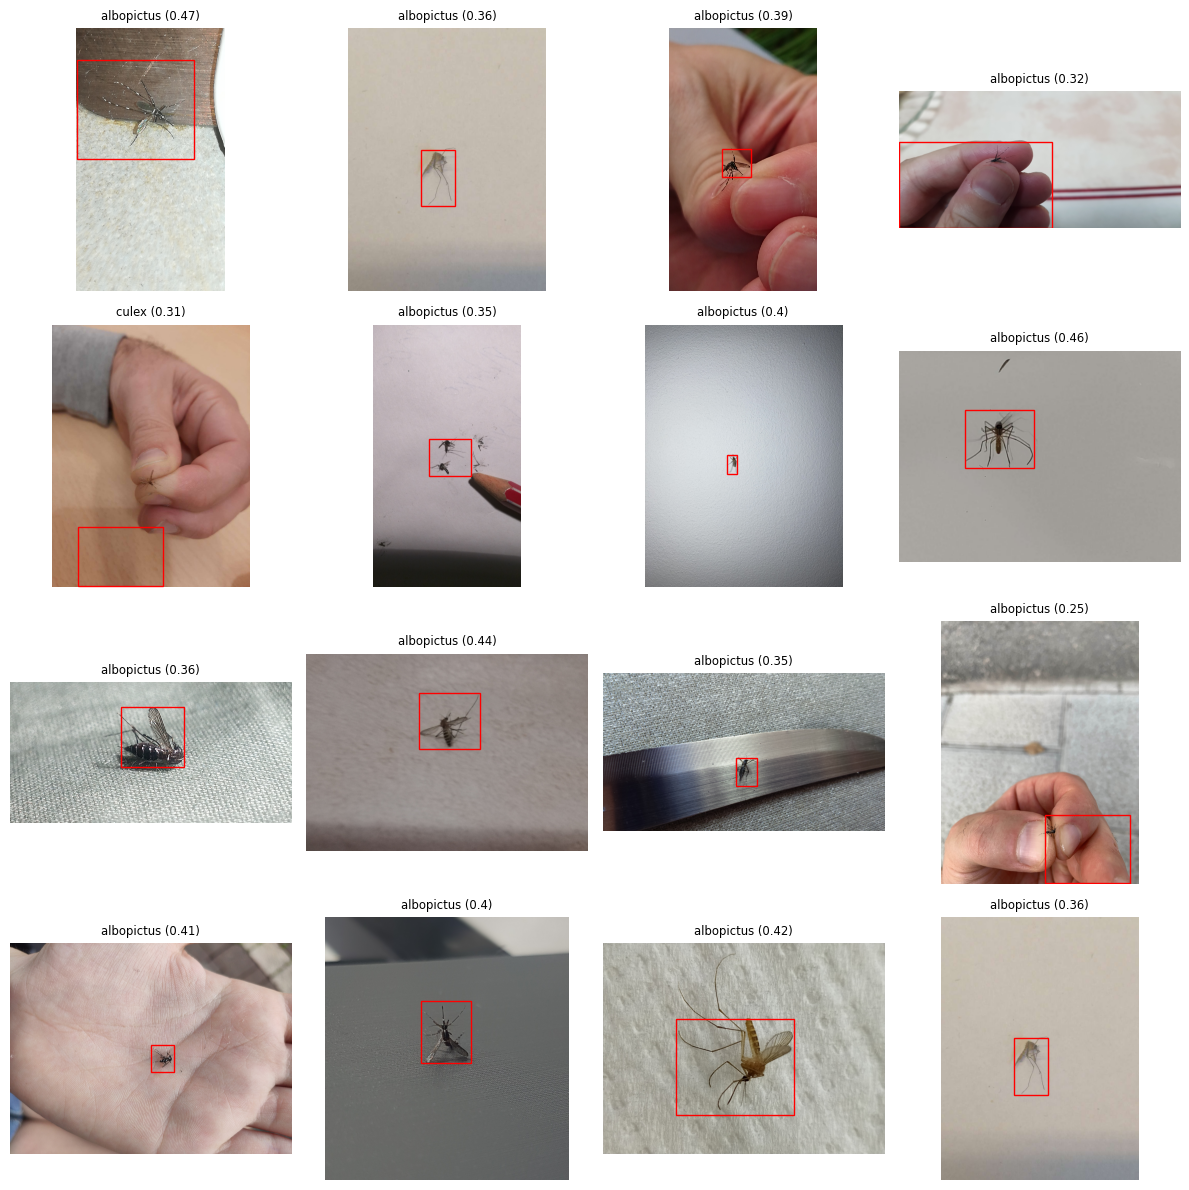

In [3]:
import json
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
root = "/kaggle/input/dlp-object-detection/final_dlp_data/final_dlp_data/train/"
dftrain, dftest = make_df(root, stratify=True)
dstrain, dstest = TrainDataset(dftrain, root), TrainDataset(dftest, root)
model = get_model(device)
train_loader = DataLoader(
    dstrain, batch_size=16, shuffle=True,  num_workers=4,
    collate_fn=partial(collate, resize=True),
)
test_loader = DataLoader(
    dstest, batch_size=8, shuffle=False, num_workers=2,
    collate_fn=partial(collate, resize=True)

)
history = train(model, train_loader, test_loader, n_epochs=3)
with open("history.json", "w") as f_out:
    json.dump(history, f_out, indent=2)
make_submission(model, "/kaggle/input/dlp-object-detection/final_dlp_data/final_dlp_data/test/images/",
                show=4, dfpath="/kaggle/input/dlp-object-detection/sample_submission.csv")